# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

In [423]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math

# Pre-implemented environments
We provide you the implementation of all the environments that you would use to finish this assignment. They are:
- **Blocking Maze**: Please read the Example 8.2 (on page 166 in RL2e) for more details
- **Shortcut Maze**: Please read the Example 8.3 (on page 167 in RL2e) for more details
- **Stochastic Windy GridWorld**: Please read the Example 6.5 (on page 130 in RL2e) for more details

For all the environments, in general, they consist of:
- A **grid** that represents the domain space. In other words, the state space contains the coordinates (e.g., [x, y]) of all empty cells that are accessible by the agent. 
- A discrete **action space** that contains 4 actions: up, down, left and right. Specifically, the **step** function in each implementation takes a **string variable** that contains the name of the action.
- All the tasks are episodic task. But, please read the description carefully in the book. Because in some task, a new episode will start only when the agent reaches the goal location. In other words, they might not have a timeout.

# Blocking Maze
In **Blocking Maze**, the agent starts the experiment by interacting with the maze on the left. Then, at time step = 1000, the environment is switched to the maze on the right. For each episode, the agent always starts at the start location (marked as S) and is asked to navigate to the goal location (marked as G). The agent receives reward = 1 when it reaches the goal and receives 0 otherwise. 

Before you use this implementation, please read the code and make sure you understand it. You are also welcome to implement your own version. If you do that, please replace the following block with your own implementation and add reasonable comments

In [424]:
class BlockingMaze(object):
    """ Implementation of the Blocking Maze """
    def __init__(self):
        # We define the grid for the maze on the left in Example 8.2
        self.left_grid = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [1, 1, 1, 1, 1, 1, 1, 1, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0]])

        # We define the grid for the maze on the right in Example 8.2
        self.right_grid = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 1, 1, 1, 1, 1, 1, 1, 1],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0]])

        # We initialize the grid with using the left maze first
        self.grid = self.left_grid.copy()
        # Save the size of the maze
        self.grid_height, self.grid_width = self.grid.shape

        # We define the observation space using all empty cells.
        # We consider all cells. Because the environment switch will results in change of the state space
        self.observation_space = np.argwhere(np.zeros((self.grid_height, self.grid_width)) == 0.0).tolist()

        # We define the action space
        self.action_space = {
            "up": np.array([-1, 0]),
            "down": np.array([1, 0]),
            "left": np.array([0, -1]),
            "right": np.array([0, 1])
        }
        self.action_names = ["up", "down", "left", "right"]

        # We define the start state
        self.start_location = [5, 3]

        # We define the goal state
        self.goal_location = [0, 8]

        # We find all wall locations in the grid
        self.walls = np.argwhere(self.grid == 1.0).tolist()

        # We define other useful variables
        self.agent_location = None
        self.action = None

    def reset(self, shift_maze=None):
        """
        Args:
            shift_maze (string): if None, reset function simply set the agent back to the start location
                                 if left, reset function will switch to the maze on the left
                                 if right, reset function will switch to the maze on the right
        """
        if shift_maze is not None:
            if shift_maze == "left":
                self.grid = self.left_grid.copy()
            elif shift_maze == "right":
                self.grid = self.right_grid.copy()
            else:
                raise Exception("Invalid shift operation")

            # reset the shape
            self.grid_height, self.grid_width = self.grid.shape

            # reset the walls
            self.walls = np.argwhere(self.grid == 1.0).tolist()

        # We reset the agent location to the start state
        self.agent_location = self.start_location

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): name of the action (e.g., "up"/"down"/"left"/"right")
        """
        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the abstract action to movement array
        act_arr = self.action_space[action]

        # Compute the next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([self.grid_height - 1, self.grid_width - 1])).tolist()

        # Check if it crashes into a wall
        if next_agent_location in self.walls:
            # If True, the agent keeps in the original state
            next_agent_location = self.agent_location

        # Compute the reward
        reward = 1 if next_agent_location == self.goal_location else 0

        # Check the termination
        terminated = True if reward == 1 else False

        # Update the action location
        self.agent_location = next_agent_location
        self.action = action

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.agent_location[0], self.agent_location[1]] = 2
        plot_arr[self.goal_location[0], self.goal_location[1]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.01)

# Shortcut Maze
In **Shortcut Maze**, the agent starts the experiment by interacting with the maze on the left. Then, at time step = 3000, the environment is switched to the maze on the right. For each episode, the agent always starts at the start location (marked as S) and is asked to navigate to the goal location (marked as G). The agent receives reward = 1 when it reaches the goal and receives 0 otherwise. 

Before you use this implementation, please read the code and make sure you understand it. You are also welcome to implement your own version. If you do that, please replace the following block with your own implementation and add reasonable comments

Since **Shortcut Maze** is different with **Blocking Maze** in terms of the maze grids. We will inherit **Blocking Maze** and only change the followings:
1. Reset the grid of the left maze 
2. Reset the grid of the right maze
3. Reset the initial maze to be the left one

In [425]:
class ShortcutMaze(BlockingMaze):
    def __init__(self):
        super().__init__()
        
        # We define the grid for the maze on the left in Example 8.3
        self.left_grid = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 1, 1, 1, 1, 1, 1, 1, 1],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0]])

        # We define the grid for the maze on the right in Example 8.3
        self.right_grid = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 1, 1, 1, 1, 1, 1, 1, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0]])
        
        # We reset the domain to be the left maze first
        self.reset(shift_maze="left")
        

# The plot function 

In [438]:
def plot_curves(arr_list, legend_list, color_list, ylabel, xlable, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlable)

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    # save the figure
    plt.savefig(f"{fig_title}.png", dpi=200)

    plt.show()

# Q3: (a) - Implement Dyna-Q and Dyna-Q+ to reproduce Figure 8.4

- Use the **BlockingMaze** environment;
- Reproduce the Figure 8.4 on page 167
    - X axis: the learning time step. In other words, it is the number of time steps that agent really interacts with the environment;
    - Y axis: the cumulative reward, a sum of all rewards received by the agent by a particular time step t. 
- Hyperparameters:
    - Dyna-Q:
        - learning time steps: 3000
        - planning steps number: 250
        - alpha: 0.1
        - gamma: 0.95
        - epsilon: 0.1
        - time to switch the maze: 1000
    - Dyna-Q+:
        - learning time steps: 3000
        - planning steps number: 250
        - alpha: 0.1
        - gamma: 0.95
        - epsilon: 0.1
        - kappa: 5e-4
        - time to switch the maze: 1000
        
Note that, to implement the Dyna-Q+, please read the section 8.3 and the footnote on page 168 carefully. For Dyna-Q+, we ask you to implement **two variants**. For the first variant, it does **not** use the strategy in the footnote. For the second, it use the strategy proposed in the footnote. Finally, besides the two lines in Figure 8.4, please add a third line for Dyna-Q+ without using the footnote strategy. 

In [427]:
""" We will implement the Dyna-Q as a class that contains the following attributes:
        - self.env: an environment object
        - self.q_table: a 2-D array with shape (num_state, num_action) that stores the Q values 
        - self.model: a nested dictionary that stores the past experiences
    Note that:
        There exists one attribute "self.maze_switch_time". It indicates the time to switch from the left maze
        to the right maze during the learning process.
        
    Please complete this class by adding your implementation in the following functions:
        - self.update_model
        - self.update_q_table
        - self.run_planning_step
        - self.run
              
"""
class TabularDynaQAgent(object):
    def __init__(self, env, info):
        # Store the environment
        self.env = env

        # Store the maximal learning steps
        self.k = info['learning_step']

        # Store the planning steps
        self.n = info['planning_step']

        # Store the Q-learning step size alpha
        self.alpha = info['alpha']

        # Store the discount factor
        self.gamma = info['gamma']

        # Initialize the epsilon for epsilon-greedy policy
        self.epsilon = info['epsilon']

        # Initialize the switch time
        self.maze_switch_time = info['switch_time_step']
        
        # Compute total number of the state
        self.state_num = len(self.env.observation_space)

        # Compute the number of the actions
        self.action_num = len(self.env.action_names)

        # Initialize the Q(s, a): a table stores (s, a)
        self.q_table = np.zeros((self.state_num, self.action_num))

        # Initialize the model
        # We represent the model as a dictionary of dictionary.
        # Specifically, the keys for the outside dictionary is a state tuple (the key should be immutable).
        # Given one state tuple key, its value is also a dictionary whose keys are actions names and values are a tuple consisting of (reward, next_state).
        # Given an empty model and a transition (s, a, r, s'), the self.model can be updated as
        # {s: {a: (r, s')}}.
        # E.g. {(0, 0): {'right': (0, [0, 2]), 'left': (0, [0, 0]), ...}, ...}
        # We usually call (s, a, r, s') a transition tuple
        self.model = {}

    def _get_state_idx(self, state):
        """
        Function returns the index of the state in the q table (i.e., row index)
        Args:
             state (tuple): a tuple contains the state
        """
        state = list(state)
        return self.env.observation_space.index(state)

    def _get_action_idx(self, action):
        """
        Function returns the index of the action in the q table (i.e., column index)
        Args:
            action (string): action name
        """
        return self.env.action_names.index(action)

    def epsilon_greedy_policy(self, state):
        """
        Function implements the epsilon-greedy policy
        Args:
            state (tuple): a tuple contains the state
        """
        if random.random() < self.epsilon:  # with p = epsilon, we randomly sample an action
            return random.sample(self.env.action_names, 1)[0]
        else:  # With p = 1 - epsilon, derive a greedy policy from the Q table
            state_idx = self._get_state_idx(state)
            q_values = self.q_table[state_idx]
            max_action_list = np.where(q_values == q_values.max())[0].tolist()
            max_action_idx = random.sample(max_action_list, 1)[0]
            return self.env.action_names[max_action_idx]  # break ties

    def update_model(self, s, a, r, next_s):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
        """
        """ CODE HERE: adding transition to the model """
        tuple_s = tuple(s)
        # check whether tuple s is a key in the dictionary
        if tuple_s not in self.model:
            self.model[tuple_s] = {}
        # update the model by adding the transition as "tuple s": {a: (r, next_s)}
        self.model[tuple_s][a] = (r, next_s)
            

    def update_q_table(self, s, a, r, next_s):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
        """
        """ CODE HERE: Q-learning """
        # obtain the table index for s and next_s
        s_index = self._get_state_idx(s)
        next_s_index = self._get_state_idx(next_s)
        # obtain the table index for a
        a_index = self._get_action_idx(a)
        # update the Q table
        self.q_table[s_index, a_index] += self.alpha*(r + self.gamma*max(self.q_table[next_s_index]) - self.q_table[s_index, a_index])
        
    def run_planning_step(self):
        """ CODE HERE: planning step see (f) in the pseudocode """
        for _ in range(self.n):
            # randomly sample a previously observe state, you can sample it from the self.model.keys()
            state = random.choice(list(self.model.keys()))
            
            # randomly sample an action previously taken in state, you can sample it from the self.model[state].keys()
            action = random.choice(list(self.model[state].keys()))
            
            # render the reward and the next state given the state and action use the model
            reward, next_state = self.model[state][action]

            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)

    def run(self):
        # record the reward
        cumulative_reward = 0

        # save the cumulative reward w.r.t. each time step
        cumulative_rewards_wrt_time_steps = np.zeros(self.k)

        # Dyna-Q starts
        state, _ = self.env.reset()
        for t in range(self.k):
            """ CODE HERE: finish the Dyna-Q learning, you should use state, action, reward, next_state, done 
                as variables names to avoid bugs.
            """
            # derive an action with epsilon-greedy policy
            action = self.epsilon_greedy_policy(state)

            # take the action and observe reward and next state
            next_state, reward, done, _, _ = self.env.step(action)

            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)

            # update model
            self.update_model(state, action, reward, next_state)

            # planning starts
            self.run_planning_step()

            # uncomment print info for debug
            # print(f"t = {t}, s = {state}, a = {action}, r = {reward}, next_s = {next_state}, done = {done}")
            
            """ SAVE PLOTTING RESULTS DO NOT CHANGE """
            # store the cumulative rewards
            cumulative_reward += reward
            cumulative_rewards_wrt_time_steps[t] = cumulative_reward

            # reset the environment
            if t == self.maze_switch_time:
                state, _ = self.env.reset(shift_maze="right")
            else:
                if done:
                    state, _ = self.env.reset()
                else:
                    state = next_state

        return cumulative_rewards_wrt_time_steps

In [428]:
""" Here is the implementation of Dyna-Q+ without the footnote strategy. 
    We will inherit from the Dyna-Q above.
    
    Recall, to compute the "bonus reward" = r + kappa * sqrt(elapsed time) for each planning step, 
    We have to store (s, a, r, s', t) in Dyna-Q+ instead of (s, a, r, s') in Dyna-Q in the model.
    Therefore, since we have to store an extra t, we only have to change three methods:
        - self.run: Because we use it to collect (s, a, r, s', t)
        - self.update_model: Because we use it to add transitions to the model.
        - self.run_planning_step: Because we use it to compute the "bonus reward" = r + kappa * sqrt(time elasped)
"""
class TabularDynaQPlusAgent(TabularDynaQAgent):
    def __init__(self, env, info):
        super().__init__(env, info)
        
        # add one parameter "kappa" to compute the bonus reward defined as: r + kappa * sqrt(elapsed time steps)
        self.kappa = info['kappa']
        
    def update_model(self, s, a, r, next_s, last_t):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
            last_t (int): the real time step that the transition is encountered
        """
        """ CODE HERE """
        # similar to the previous update. This time add last_t as one component
        tuple_s = tuple(s)
        # check whether tuple s is a key in the dictionary
        if tuple_s not in self.model:
            self.model[tuple_s] = {}
        # update the model by adding the transition as "tuple s": {a: (r, next_s)}
        self.model[tuple_s][a] = (r, next_s, last_t)
    
        
    def run_planning_step(self, current_t):
        """
        Args:
            current_t (int): current time step in the learning process. We use it as well as the time recorded in
            each transition to compute the elasped time. 
        """
        for _ in range(self.n):
            """ CODE HERE: Dyna-Q with bonus reward no footnote """
            # randomly sample a previously observe state
            state = random.choice(list(self.model.keys()))
            # randomly sample an action previously taken in state
            action = random.choice(list(self.model[state].keys()))
            # render the reward and the next state given the state and action use the model
            reward, next_state, last_t = self.model[state][action]
            # compute the "bonus" reward = r + kappa * sqrt(time elasped)
            reward += self.kappa*math.sqrt(current_t - last_t)
            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)
            
    def run(self):
        # record the reward
        cumulative_reward = 0

        # save the cumulative reward w.r.t. each time step
        cumulative_rewards_wrt_time_steps = np.zeros(self.k)

        # Dyna-Q starts
        state, _ = self.env.reset()
        for t in range(self.k):
            """ CODE HERE: finish the code for Dyna-Q+ 
                Please use state, action, reward, next_state, done as variable names to avoid bugs.
            """
            # derive an action with epsilon-greedy policy
            action = self.epsilon_greedy_policy(state)
            # take the action and observe reward and next state
            next_state, reward, done, _, _  = self.env.step(action)
            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)
            # update model
            self.update_model(state, action, reward, next_state, t)
            # planning step
            self.run_planning_step(t)
            # uncomment print info for debug
            # print(f"t = {t}, s = {state}, a = {action}, r = {reward}, next_s = {next_state}, done = {done}")

            """ SAVE PLOTTING RESULTS DO NOT CHANGE """
            # store the cumulative rewards
            cumulative_reward += reward
            cumulative_rewards_wrt_time_steps[t] = cumulative_reward

            # reset the environment
            if t == self.maze_switch_time:
                state, _ = self.env.reset(shift_maze="right")
            else:
                if done:
                    state, _ = self.env.reset()
                else:
                    state = next_state

        return cumulative_rewards_wrt_time_steps

In [429]:
""" Here is the implementation of Dyna-Q+ with the footnote strategy. 
    We will inherit from the Dyna-Q+ without footnote above.
    
    Recall, the only difference between the two variants of Dyna-Q+ is whether we consider untried actions 
    from a state during the planning stage. Therefore, based on the footnote, we only have to change one method:
        - self.run_planning_step:
            - We will compute the "bonus reward" = r + kappa * sqrt(time elasped)
            - We will try untried actions from state (See footnote on p.168 for more details)
"""
class TabularDynaQPlusAgentFontNote(TabularDynaQPlusAgent):
    def __init__(self, env, info):
        super().__init__(env, info)
        
    def run_planning_step(self, current_t):
        """
        Args:
            current_t (int): current time step in the learning process. We use it as well as the time recorded in
            each transition to compute the elasped time. 
        """
        for _ in range(self.n):
            """ CODE HERE: Dyna-Q+ with footnote + bonus reward """
            # randomly sample a previously observe state
            state = random.choice(list(self.model.keys()))
            # randomly sample an action (all actions in the action space
            # are valid from one state based on the footnote)
            action = random.choice(self.env.action_names)
            # check if the action is tried before
                # If True, render the reward and the next state given the state and action use the model
                # If False, set values for the reward, next_state, and t suggested by the footnote
            if action in self.model[state]:
                reward, next_state, last_t = self.model[state][action]
            else:
                reward, next_state, last_t = 0, state, 0
            # compute the "bonus" reward
            reward += self.kappa*math.sqrt(current_t - last_t)
            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)
            

In [430]:
class NStepTabularDynaQAgent(TabularDynaQAgent):
    def __init__(self, env, info):
        super().__init__(env, info)
    
    def update_q_table(self, ep_steps,  next_s, n):
        t = len(ep_steps) - n 
        if t >=0: 
            G = 0 
            for i in range(t, len(ep_steps)):
                G += self.gamma**(i-t)*ep_steps[i][2]
            if next_s != self.env.goal_location:
                next_s_index = self._get_state_idx(next_s)
                G += self.gamma**(n)*max(self.q_table[next_s_index])
            s_index = self._get_state_idx(ep_steps[t][0])
            a_index = self._get_action_idx(ep_steps[t][1])
            self.q_table[s_index, a_index] += self.alpha*(G - self.q_table[s_index, a_index])
        
    def run_planning_step(self):
        """ CODE HERE: planning step see (f) in the pseudocode """
        for _ in range(self.n):
            # randomly sample a previously observe state, you can sample it from the self.model.keys()
            state = random.choice(list(self.model.keys()))
            
            # randomly sample an action previously taken in state, you can sample it from the self.model[state].keys()
            action = random.choice(list(self.model[state].keys()))
            
            # render the reward and the next state given the state and action use the model
            reward, next_state = self.model[state][action]

            # update the Q table using Q-learning
            self.update_q_table([(state, action, reward)], next_state, 1)    
        
    def run(self):
        # record the reward
        cumulative_reward = 0

        # save the cumulative reward w.r.t. each time step
        cumulative_rewards_wrt_time_steps = np.zeros(self.k)
        ep_steps = []
        
        # Dyna-Q starts
        state, _ = self.env.reset()
        for t in range(self.k):
            """ CODE HERE: finish the code for Dyna-Q+ 
                Please use state, action, reward, next_state, done as variable names to avoid bugs.
            """
            # derive an action with epsilon-greedy policy
            action = self.epsilon_greedy_policy(state)
            # take the action and observe reward and next state
            next_state, reward, done, _, _  = self.env.step(action)
            ep_steps.append((state, action, reward))
            # update the Q table using Q-learning
            self.update_q_table(ep_steps, next_state, 5)
            # update model
            self.update_model(state, action, reward, next_state)
            # planning step
            self.run_planning_step()
            # uncomment print info for debug
            # print(f"t = {t}, s = {state}, a = {action}, r = {reward}, next_s = {next_state}, done = {done}")

            """ SAVE PLOTTING RESULTS DO NOT CHANGE """
            # store the cumulative rewards
            cumulative_reward += reward
            cumulative_rewards_wrt_time_steps[t] = cumulative_reward

            # reset the environment
            if t == self.maze_switch_time:
                state, _ = self.env.reset(shift_maze="right")
            else:
                if done:
                    ep_steps = []
                    state, _ = self.env.reset()
                else:
                    state = next_state

        return cumulative_rewards_wrt_time_steps

# Run experiment

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.71s/it]


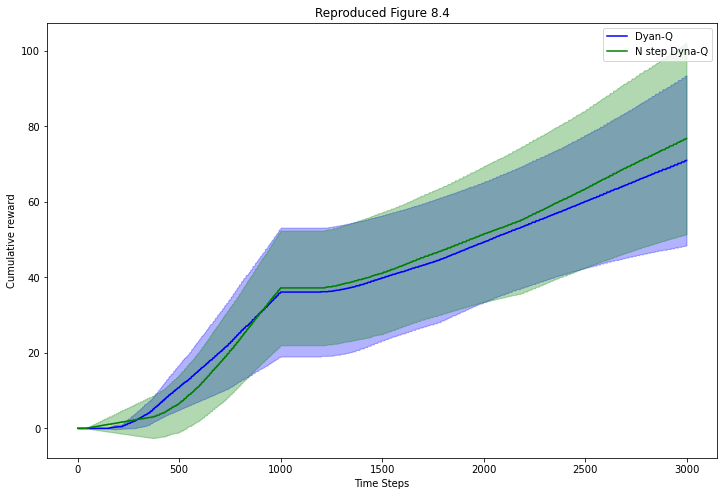

In [431]:
""" Here is the code to reproduce the Figure 8.4. It takes on average around 1 min (Macbook Pro M1)
    to run one method using the following parameters for experiments:
        - learning step = 3000
        - planning step = 250
        - alpha (Q-learning update step) = 0.1
        - gamma (discount factor) = 0.95
        - epsilon (epsilon-greedy) = 0.1
        - kappa ("bonus reward") = 5e-4
        
    We run 10 trials and plot the results. 
"""
if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "switch_time_step": 1000,
        "learning_step": 3000,
        "planning_step": 250,
        "alpha": 0.1,
        "gamma": 0.95,
        "epsilon": 0.1,
        "kappa": 5e-4
    }

    """ Set running trials for experiments 
    """
    run_trial_num = 10

    """ Run N step Dyna-Q
    """
    results_n_step_dyna_q = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = BlockingMaze()

        # create the agent for Dyna-Q
        n_step_dyna_q_agent = NStepTabularDynaQAgent(my_env, params)
        result = n_step_dyna_q_agent.run()

        results_n_step_dyna_q.append(result)

    """ Run Dyna-Q
    """    
    results_dyna_q = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = BlockingMaze()

        # create the agent for Dyna-Q
        dyna_q_agent = TabularDynaQAgent(my_env, params)
        result = dyna_q_agent.run()

        results_dyna_q.append(result)    
        
    """ Plot the results
    """
    plot_curves([np.array(results_dyna_q), np.array(results_n_step_dyna_q)],
                ["Dyan-Q", "N step Dyna-Q"],
                ["b","g"],
                "Cumulative reward","Time Steps",  "Reproduced Figure 8.4")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.58s/it]


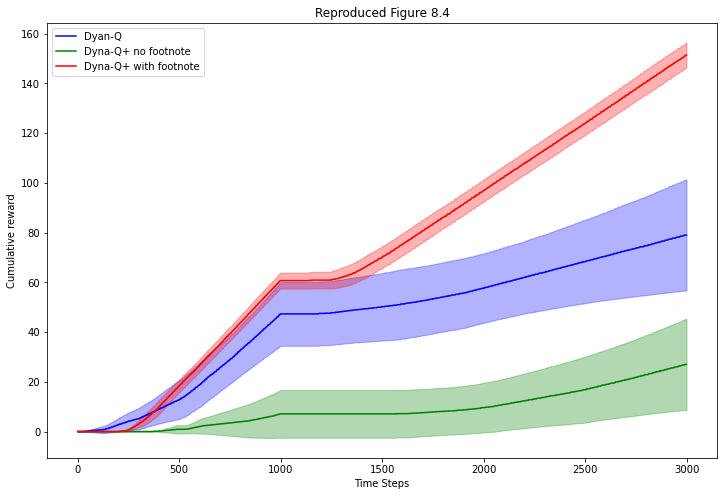

In [439]:
""" Here is the code to reproduce the Figure 8.4. It takes on average around 1 min (Macbook Pro M1)
    to run one method using the following parameters for experiments:
        - learning step = 3000
        - planning step = 250
        - alpha (Q-learning update step) = 0.1
        - gamma (discount factor) = 0.95
        - epsilon (epsilon-greedy) = 0.1
        - kappa ("bonus reward") = 5e-4
        
    We run 10 trials and plot the results. 
"""
if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "switch_time_step": 1000,
        "learning_step": 3000,
        "planning_step": 250,
        "alpha": 0.1,
        "gamma": 0.95,
        "epsilon": 0.1,
        "kappa": 5e-4
    }

    """ Set running trials for experiments 
    """
    run_trial_num = 10

    """ Run Dyna-Q
    """
    results_dyna_q = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = BlockingMaze()

        # create the agent for Dyna-Q
        dyna_q_agent = TabularDynaQAgent(my_env, params)
        result = dyna_q_agent.run()

        results_dyna_q.append(result)

    """ Run Dyna-Q+ without the footnote
    """
    results_dyna_q_plus = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = BlockingMaze()

        # create the agent for Dyna-Q
        dyna_q_plus_agent = TabularDynaQPlusAgent(my_env, params)
        result = dyna_q_plus_agent.run()

        results_dyna_q_plus.append(result)

    """ Run Dyna-Q+ with the footnote
    """
    results_dyna_q_plus_fn = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = BlockingMaze()

        # create the agent for Dyna-Q
        dyna_q_plus_agent_fn = TabularDynaQPlusAgentFontNote(my_env, params)
        result = dyna_q_plus_agent_fn.run()

        results_dyna_q_plus_fn.append(result)

    """ Plot the results
    """
    plot_curves([np.array(results_dyna_q), np.array(results_dyna_q_plus), np.array(results_dyna_q_plus_fn)],
                ["Dyan-Q", "Dyna-Q+ no footnote", "Dyna-Q+ with footnote"],
                ["b", "g", "r"],
                "Cumulative reward", "Time Steps","Reproduced Figure 8.4")

# Q3: (b) - Implement Dyna-Q and Dyna-Q+ to reproduce Figure 8.5

- Use the **ShortcutMaze** environment;
- Reproduce the Figure 8.5 on page 167
    - X axis: the learning time step. In other words, it is the number of time steps that agent really interacts with the environment;
    - Y axis: the cumulative reward, a sum of all rewards received by the agent till a particular time step t. 
- Hyperparameters:
    - Dyna-Q:
        - learning time steps: 6000
        - planning steps number: 250
        - alpha: 0.1
        - gamma: 0.95
        - epsilon: 0.1
        - time to switch the maze: 3000
    - Dyna-Q+:
        - learning time steps: 6000
        - planning steps number: 250
        - alpha: 0.1
        - gamma: 0.95
        - epsilon: 0.1
        - kappa: 5e-4
        - time to switch the maze: 3000
        
Note that, to implement the Dyna-Q+, please read the section 8.3 and the footnote on page 168 carefully. For Dyna-Q+, we ask you to implement **two variants**. For the first variant, it does **not** use the strategy in the footnote. For the second, it use the strategy proposed in the footnote. Finally, besides the two lines in Figure 8.5, please add a third line for Dyna-Q+ without using the footnote strategy. 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.16s/it]


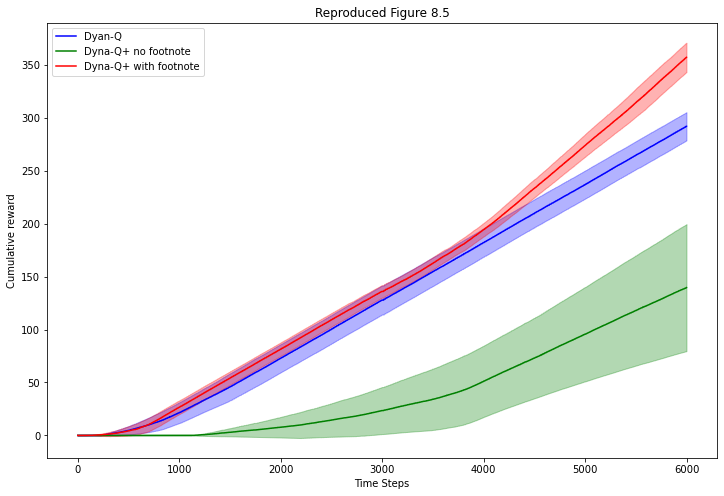

In [434]:
""" Great! You have successfully implement Dyna-Q and Dyna-Q+.
    To reproduce the Figure 8.5, just change the environment to be ShortcutMaze. 
    
    It takes on average 2 mins on a Macbook Pro with M1. 
"""

if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "switch_time_step": 3000,
        "learning_step": 6000,
        "planning_step": 250,
        "alpha": 0.1,
        "gamma": 0.95,
        "epsilon": 0.1,
        "kappa": 5e-4
    }

    """ Set running trials for experiments 
    """
    run_trial_num = 10

    """ Run Dyna-Q
    """
    results_dyna_q = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = ShortcutMaze()

        # create the agent for Dyna-Q
        dyna_q_agent = TabularDynaQAgent(my_env, params)
        result = dyna_q_agent.run()

        results_dyna_q.append(result)

    """ Run Dyna-Q+ without the footnote
    """
    results_dyna_q_plus = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = ShortcutMaze()

        # create the agent for Dyna-Q
        dyna_q_plus_agent = TabularDynaQPlusAgent(my_env, params)
        result = dyna_q_plus_agent.run()

        results_dyna_q_plus.append(result)

    """ Run Dyna-Q+ with the footnote
    """
    results_dyna_q_plus_fn = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = ShortcutMaze()

        # create the agent for Dyna-Q
        dyna_q_plus_agent_fn = TabularDynaQPlusAgentFontNote(my_env, params)
        result = dyna_q_plus_agent_fn.run()

        results_dyna_q_plus_fn.append(result)

    plot_curves([np.array(results_dyna_q), np.array(results_dyna_q_plus), np.array(results_dyna_q_plus_fn)],
                ["Dyan-Q", "Dyna-Q+ no footnote", "Dyna-Q+ with footnote"],
                ["b", "g", "r"],
                "Cumulative reward","Time steps", "Reproduced Figure 8.5")

# Q4: Modify Dyna-Q to solve the Stochastic Windy GridWorld

Please implement your modification to the original Dyan-Q algorithm and make it suitable to resolve a stochastic environment. In this case, we use the **stochastic Windy GridWorld** to test your implemtation.

The environment implementation is as follows. You can use it directly or implement your own one. However, if you implement your own version, please make sure it is **correct** and **bug-free** and **well commented**. We would not be able to give credits if the environment implementation does not work properly or can not be understood. 

You can adopt your implementation of Dyna-Q above and make the changes. To show your results, you are asked to provide the followings:

1. **Plot a figure** similar to Figure 8.2 in RL2e. Specifically, the x axis is the number of finished episodes; the y axis is the number of the time steps per episode. Note that, you do **not** need to plot curves for different planning steps (i.e., n). Just tune the n that works the best for you and plot the curve for that particular n (i.e., you might find n = 100 works the best in your case). 
2. **Print out the optimal path** that the algorithm finds by the end of the learning. In particular, you should write a code to do the followings:
    - Reset the agent back to the start location;
    - Write a for loop to let the agent interact with the environment automatically;
    - At each time step, derive a greedy action using the Q table by the end of the learning;
    - Observe the next state and reward by taking the action in the environment;
    - Print out the followings for each time step:
        - Time step stamp
        - State (agent's previous location)
        - Action (action just taken by the agent)
        - Reward (reward for taking that action from previous location)
        - Next state (location that agent results in after taking the action)
        - Done (termination signal to show whether the episode is terminated)
    
 For example, at time step 0, your code should print the followings:
 
     "time step = 0, state = [3, 0], action = "up", reward = 0, next_state = [2, 0], done = False"
 
 A good policy can guide the agent from the start location to the goal location successfully.  

In [77]:
class StochasticWindyGridWorld(object):
    def __init__(self):
        # We define the grid for the DynaMaze domain
        self.grid = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        self.grid_height, self.grid_width = self.grid.shape

        # We define the observation space consisting of all empty cells
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()

        # We define the action space
        self.action_space = {
            "up": np.array([-1, 0]),
            "down": np.array([1, 0]),
            "left": np.array([0, -1]),
            "right": np.array([0, 1])
        }
        # We define the action names
        self.action_names = ['up', 'down', 'left', 'right']

        # We define the start state
        self.start_location = [3, 0]

        # We define the goal state
        self.goal_location = [3, 7]

        # Define the wind list
        self.wind_space = (0, 0, 0, 1, 1, 1, 2, 2, 1, 0)

        # We define other useful variables
        self.agent_location = None
        self.action = None

    def reset(self):
        # We reset the agent location to the start state
        self.agent_location = self.start_location

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): name of the action (e.g., "up"/"down"/"left"/"right")
        """
        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_space[action]

        # Make the wind stochastic
        mean_wind = self.wind_space[self.agent_location[1]]
        if mean_wind:  # if the wind exists
            wind = np.random.choice([mean_wind - 1,
                                     mean_wind,
                                     mean_wind + 1],
                                    p=[1.0/3.0, 1.0/3.0, 1.0/3.0])
        else:
            wind = 0
        # Compute the wind array
        wind_arr = -1 * np.array([wind, 0], dtype=int)

        # compute the next state
        next_agent_location = np.clip(loc_arr + act_arr + wind_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([self.grid_height - 1, self.grid_width - 1])).tolist()

        # Compute the reward
        reward = 0 if next_agent_location == self.goal_location else -1

        # Check the termination
        terminated = True if reward == 0 else False

        # Update the action location
        self.agent_location = next_agent_location
        self.action = action

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.agent_location[0], self.agent_location[1]] = 2
        plot_arr[self.goal_location[0], self.goal_location[1]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.5)

# Implement your modification to Dyna-Q here

In [166]:
""" CODE YOUR MODIFICATION TO DYNA-Q HERE:
    Tip: you can inherit the Dyna-Q above and change the methods as you wish.
"""       
class StocasticTabularDynaQAgent(TabularDynaQAgent):
    def __init__(self, env, info):
        super().__init__(env, info)
        self.episodes = info['episodes']
        
    def update_model(self, s, a, r, next_s):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
        """
        """ CODE HERE: adding transition to the model """
        tuple_s = tuple(s)
        # check whether tuple s is a key in the dictionary
        if tuple_s not in self.model:
            self.model[tuple_s] = {}
        # update the model by adding the transition as "tuple s": {a: (r, next_s)}
        if a not in self.model[tuple_s]:
            self.model[tuple_s][a] = [(r, next_s)]
        else:
            self.model[tuple_s][a].append((r, next_s))
    
    def run_planning_step(self):
        """ CODE HERE: planning step see (f) in the pseudocode """
        for _ in range(self.n):
            # randomly sample a previously observe state, you can sample it from the self.model.keys()
            state = random.choice(list(self.model.keys()))
            
            # randomly sample an action previously taken in state, you can sample it from the self.model[state].keys()
            action = random.choice(list(self.model[state].keys()))
            
            # render the reward and the next state given the state and action use the model
            reward, next_state = random.choice(self.model[state][action])

            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)
            
    def run(self):
        # save the cumulative reward w.r.t. each time step
        episodes_wrt_time_steps = np.zeros(self.self.episodes)

        # Dyna-Q starts
        state, _ = self.env.reset()
        episode = 0
        t = 0
        while episode < self.episodes:
            """ CODE HERE: finish the code for Dyna-Q+ 
                Please use state, action, reward, next_state, done as variable names to avoid bugs.
            """
            # derive an action with epsilon-greedy policy
            action = self.epsilon_greedy_policy(state)
            # take the action and observe reward and next state
            next_state, reward, done, _, _  = self.env.step(action)
            t += 1
            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)
            # update model
            self.update_model(state, action, reward, next_state)
            # planning step
            self.run_planning_step()
            # uncomment print info for debug
#             print(f"t = {t}, s = {state}, a = {action}, r = {reward}, next_s = {next_state}, done = {done}")

            # reset the environment
            if done:
                episodes_wrt_time_steps[episode] = t
                episode += 1
                t = 0
                state, _ = self.env.reset()
            else:
                state = next_state

        return episodes_wrt_time_steps

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.82s/it]


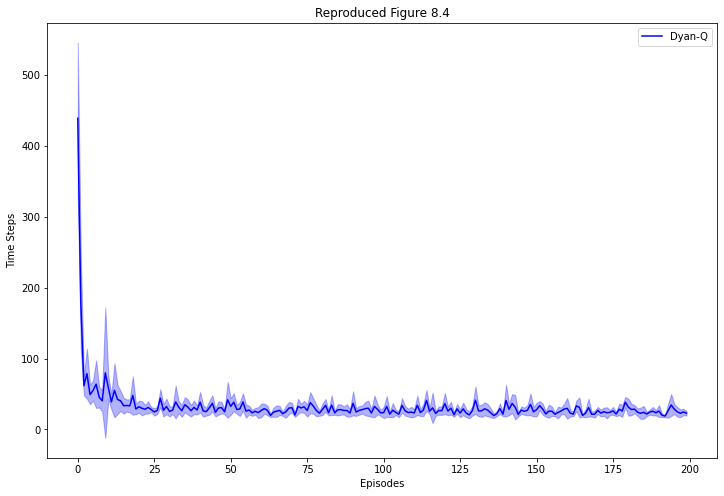

In [440]:
""" CODE YOUR SOLUTION TO PLOT THE FIGURE HERE: 
    Tips: To plot the Figure 8.2, during the learning process, you can maintain a list to store the number of
    time steps for each completed episode.
"""
if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "switch_time_step": 1000,
        "learning_step": 5000,
        "planning_step": 100,
        "episodes": 200,
        "alpha": 0.1,
        "gamma": 1,
        "epsilon": 0.1,
        "kappa": 5e-4
    }

    """ Set running trials for experiments 
    """
    run_trial_num = 10

    """ Run Dyna-Q
    """
    results_dyna_q = []
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = StochasticWindyGridWorld()

        # create the agent for Dyna-Q
        dyna_q_agent = StocasticTabularDynaQAgent(my_env, params)
        result = dyna_q_agent.run()

        results_dyna_q.append(result)

    """ Plot the results
    """
    plot_curves([np.array(results_dyna_q)],
                ["Dyan-Q"],
                ["b"],
                "Time Steps","Episodes", "Reproduced Figure 8.4")

# Print out the optimal path

In [441]:
def get_greedy_policy(state, Q):
    """ CODE HERE: How to derive a greedy action using the Q values learned from Dyna-Q"""
    # render the index of the state
    s_index = dyna_q_agent._get_state_idx(state)
    # render all q values for state 
    # find the index of the maximal q values
    a_index = np.argmax(Q[s_index], axis=0)
    # return the action corresponding to the index
    return dyna_q_agent.env.action_names[a_index]

In [443]:
# save the Q from the learning above
# replace the None with the Q table you obtained.
# Tips: you may also need to implement functions to get the index for states and actions. Therefore,
# we suggest you to inherit the Dyna-Q above and only modify some methods to deal with the stochastic env.
# Assign the learned object of the modified Dyna-Q to Q. You will have the flexibility to render indices and
# render Q values, which is an attribute in the object. 
Q =  dyna_q_agent.q_table
# create an instance of the env to print the optimal path
test_env = StochasticWindyGridWorld()

# reset the agent back to the start location
state, _ = test_env.reset()

for t in range(1000):
    """ CODE HERE: 
        Implement a function that returns a greedy action (string) based on the current state
        using the Q table obtained by the modified Dyna-Q.
        Note that, action should be string variable (e.g., "up").
        Replace the None with your implementation
    """
    action = get_greedy_policy(state, Q)
    
    # interact with the environment
    next_state, reward, done, _, _ = test_env.step(action)
    
    # print the path
    print(f"Time step = {t}, State = {state}, Action = {action}, Reward = {reward}, Next_state = {next_state}, Done = {done}")
    
    # check termination
    if done:
        break
    else:
        state = next_state
    


Time step = 0, State = [3, 0], Action = right, Reward = -1, Next_state = [3, 1], Done = False
Time step = 1, State = [3, 1], Action = right, Reward = -1, Next_state = [3, 2], Done = False
Time step = 2, State = [3, 2], Action = right, Reward = -1, Next_state = [3, 3], Done = False
Time step = 3, State = [3, 3], Action = right, Reward = -1, Next_state = [1, 4], Done = False
Time step = 4, State = [1, 4], Action = right, Reward = -1, Next_state = [0, 5], Done = False
Time step = 5, State = [0, 5], Action = right, Reward = -1, Next_state = [0, 6], Done = False
Time step = 6, State = [0, 6], Action = right, Reward = -1, Next_state = [0, 7], Done = False
Time step = 7, State = [0, 7], Action = right, Reward = -1, Next_state = [0, 8], Done = False
Time step = 8, State = [0, 8], Action = right, Reward = -1, Next_state = [0, 9], Done = False
Time step = 9, State = [0, 9], Action = down, Reward = -1, Next_state = [1, 9], Done = False
Time step = 10, State = [1, 9], Action = down, Reward = -1, N